In [2]:
# Some standard import statements that are nice for Jupyter

# this is necessary for the functions.py file to be imported
# replace the path with the appropriate path to your workspace
import sys
sys.path.append('/ucn/orithyia_data/psi_transmission/scripts')
sys.path.append('/Users/jonahbd/psi_transmission/scripts')


import os
import logging
import ipynb
import decimal
import time
import uncertainties
import datetime as dt
from lmfit import Model
import matplotlib.dates as mdates
from uncertainties import *
import numpy as np
from scipy.optimize import curve_fit
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# prevents the need to reload the kernel everytime functions.py file is updated
%load_ext autoreload
%autoreload 2

# # for plotting
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# %matplotlib ipympl
# plt.rcParams['figure.dpi'] = 600
# plt.rcParams.update({'font.size': 14})
# plt.rcParams['figure.figsize'] = (6.66, 4)

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

# importing functions for analysis
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main(raw_unix_time_flag = True)

In [43]:
# proper time - main detector
exp_time_data_dict, exp_time_norm_dict = load_all_main(raw_unix_time_flag = False)

norm_dict

In [5]:
# monitor detector
monitor_data = load_monitor()

In [6]:
# 2 second proton beam current
p_beam_2s = load_p_beam_2s()

In [7]:
# 10 second proton beam current
p_beam_10s = load_p_beam_10s()

# Clarifying the Configurations

Edgard Pierre has provided some clarification of the configurations:

>There are two kinds of guides used in this experiment:<br/>
"TRIUMF-style" guides: they have flanges and have a 85 mm ID. The EP SUS guide with NiP is this kind (it actually has a number now).<br/>
"JP-style" guides: they are flangeless and have a 72.4 mm ID.

>The ideal configuration for a transmission measurement is the same configuration but without the test guide. As a result, we have two normalization configurations:<br/>
For the "TRIUMF-style" guides, remove the test guide, and connect both adapters together. It is not possible to screw both adapters together, so we clapped them.

>For the "JP-style" guides, we removed the adapters and made a special one, called SS disk in order to connect both plexi guides together.

Side-view drawings are given below for each of the four configurations. All of these drawings are available in the "PSI Transmission/Configuration Sketches" directory on the [ucntriumf@gmail.com Google Drive account](https://drive.google.com/drive/folders/1m4DZ2E8JOs_AqVn1cjwlweA_mFWuRRlt?usp=sharing).

## TRIUMF-style Test Configuration

>![](../img/triumf_test_config.png)
>![](jonahberean/psi_transmission/img/triumf_test_config.png)

## TRIUMF-style Normalization Configuration

>![](../img/triumf_norm_config.png)
>![](jonahberean/psi_transmission/img/triumf_norm_config.png)

## JP-style Test Configuration

>![](../img/jp_test_config.png)
>![](jonahberean/psi_transmission/img/jp_test_config.png)

## JP-style Normalization Configuration

>![](../img/jp_norm_config.png)
>![](jonahberean/psi_transmission/img/jp_norm_config.png)

# Edgard's Images of the Configurations

From Edgard:

>The two pictures I took (and shown in my slides) are:<br/>
"TRIUMF-style" guide measurement configuration<br/>
"JP-style" guide normalization measurement configuration

And here are those two configuration images, in respective order:

## Photo of the TRIUMF-style Test Configuration

>![](../img/photo_triumf_test_config.png)
>![](jonahberean/psi_transmission/img/photo_triumf_test_config.png)

## Photo of the JP-style Normalization Configuration

>![](../img/photo_jp_norm_config.png)
>![](jonahberean/psi_transmission/img/photo_jp_norm_config.png)


# Fitting to the Normalization Configuration Measurements

As can be seen in the run list (sorting_data notebook), the TRIUMF-style normalization configuration was repeated throughout the experiment, and therefore provides an ideal data set to use here. The goal is to provide a fit to the overall count rate, from run to run, when plotted as a function of time elapsed. By "time elapsed" I refer to the time since the start of the experimental campaign. We are looking specifically for evidence of an overall reduction in UCN counts from run to run, which we anticipate as a feature of the PSI UCN source production appratus. This reduction is the physical upshot of frost build-up on the $s_{D_2}$ source solid. Full details are available in the publication: [Solid deuterium surface degradation at ultracold neutron sources, Anghel et al. 2018](https://link.springer.com/article/10.1140%2Fepja%2Fi2018-12594-2). This article can be found in the "documents" directory of this repository.

Here is some potentially relevant information about the detector, from Bernhard Lauss:

>3) Cascade counter<br/>
you can find a short description in the Appendix f the <br/>
Doctoral Thesis of Leonard Goeltl - ETH Theses  Nr.  20350<br/>
you can download it from the <br/>
ETH Zuerich Thesis Data base

>otherwise check the website of the producer<br/>
C-DT Heidelberg.  cdt.com

## TRIUMF-style Normalization Run List

Referring to the run list, below is a reduced list of the runs that were carried out in the TRIUMF-style Normalization configuration. I refer to this configuration by the "NOMI" tag within the code and file naming. 

Run #'s            | Day | Storage Time (s) | NAME | Guide                             | Configuration              |
---                | --- |     ---          | ---  | ---                               |  ---                       |
 22 - 24           | 8   |      20          | NOMI | None                              | TRIUMF-style Normalization |
 25 - 31           | 8   |     100          | NOMI | None                              | TRIUMF-style Normalization |
 32 - 35*          | 8   |       5          | NOMI | None                              | TRIUMF-style Normalization |
      76           | 8   |  direct          | NOMI | None                              | TRIUMF-style Normalization |
 77 - 79           | 8   |       5          | NOMI | None                              | TRIUMF-style Normalization |
 80 - 82           | 8   |      20          | NOMI | None                              | TRIUMF-style Normalization |
 83 - 88$^\dagger$ | 8   |     100          | NOMI | None                              | TRIUMF-style Normalization |
      120          | 9   |  direct          | NOMI | None                              | TRIUMF-style Normalization |
121 - 123          | 9   |       5          | NOMI | None                              | TRIUMF-style Normalization |
124 - 125          | 9   |      20          | NOMI | None                              | TRIUMF-style Normalization |
      127          | 9   |      20          | NOMI | None                              | TRIUMF-style Normalization |
128 - 135          | 9   |     100          | NOMI | None                              | TRIUMF-style Normalization |
      175          | 9   |  direct          | NOMI | None                              | TRIUMF-style Normalization |
176 - 183          | 9   |     100          | NOMI | None                              | TRIUMF-style Normalization |
184 - 186          | 9   |      20          | NOMI | None                              | TRIUMF-style Normalization |
187 - 189          | 9   |       5          | NOMI | None                              | TRIUMF-style Normalization |
      122          | 10  |  direct          | NOMI | None                              | TRIUMF-style Normalization |
123 - 130          | 10  |     100          | NOMI | None                              | TRIUMF-style Normalization |
131 - 133          | 10  |      20          | NOMI | None                              | TRIUMF-style Normalization |
134 - 136          | 10  |       5          | NOMI | None                              | TRIUMF-style Normalization |
      170          | 10  |  direct          | NOMI | None                              | TRIUMF-style Normalization |
172 - 179          | 10  |     100          | NOMI | None                              | TRIUMF-style Normalization |
180 - 182          | 10  |      20          | NOMI | None                              | TRIUMF-style Normalization |
183 - 185          | 10  |       5          | NOMI | None                              | TRIUMF-style Normalization |
      249          | 10  |  direct          | NOMI | None                              | TRIUMF-style Normalization |
250 - 252          | 10  |       5          | NOMI | None                              | TRIUMF-style Normalization |
253 - 255          | 10  |      20          | NOMI | None                              | TRIUMF-style Normalization |
256 - 265          | 10  |     100          | NOMI | None                              | TRIUMF-style Normalization |

\* elog: *configuration change, background included* - cut required.<br/>
$^\dagger$ elog: *to be checked in the data (remove noise at the end)* - cut required<br/>

shot: Red. Chi Squared = 19969.548008409824
shot: degrees of freedom = 4
s005: Red. Chi Squared = 78.11820045981285
s005: degrees of freedom = 20
s020: Red. Chi Squared = 56.518615041623086
s020: degrees of freedom = 19
s100: Red. Chi Squared = 7.620689081575439
s100: degrees of freedom = 53


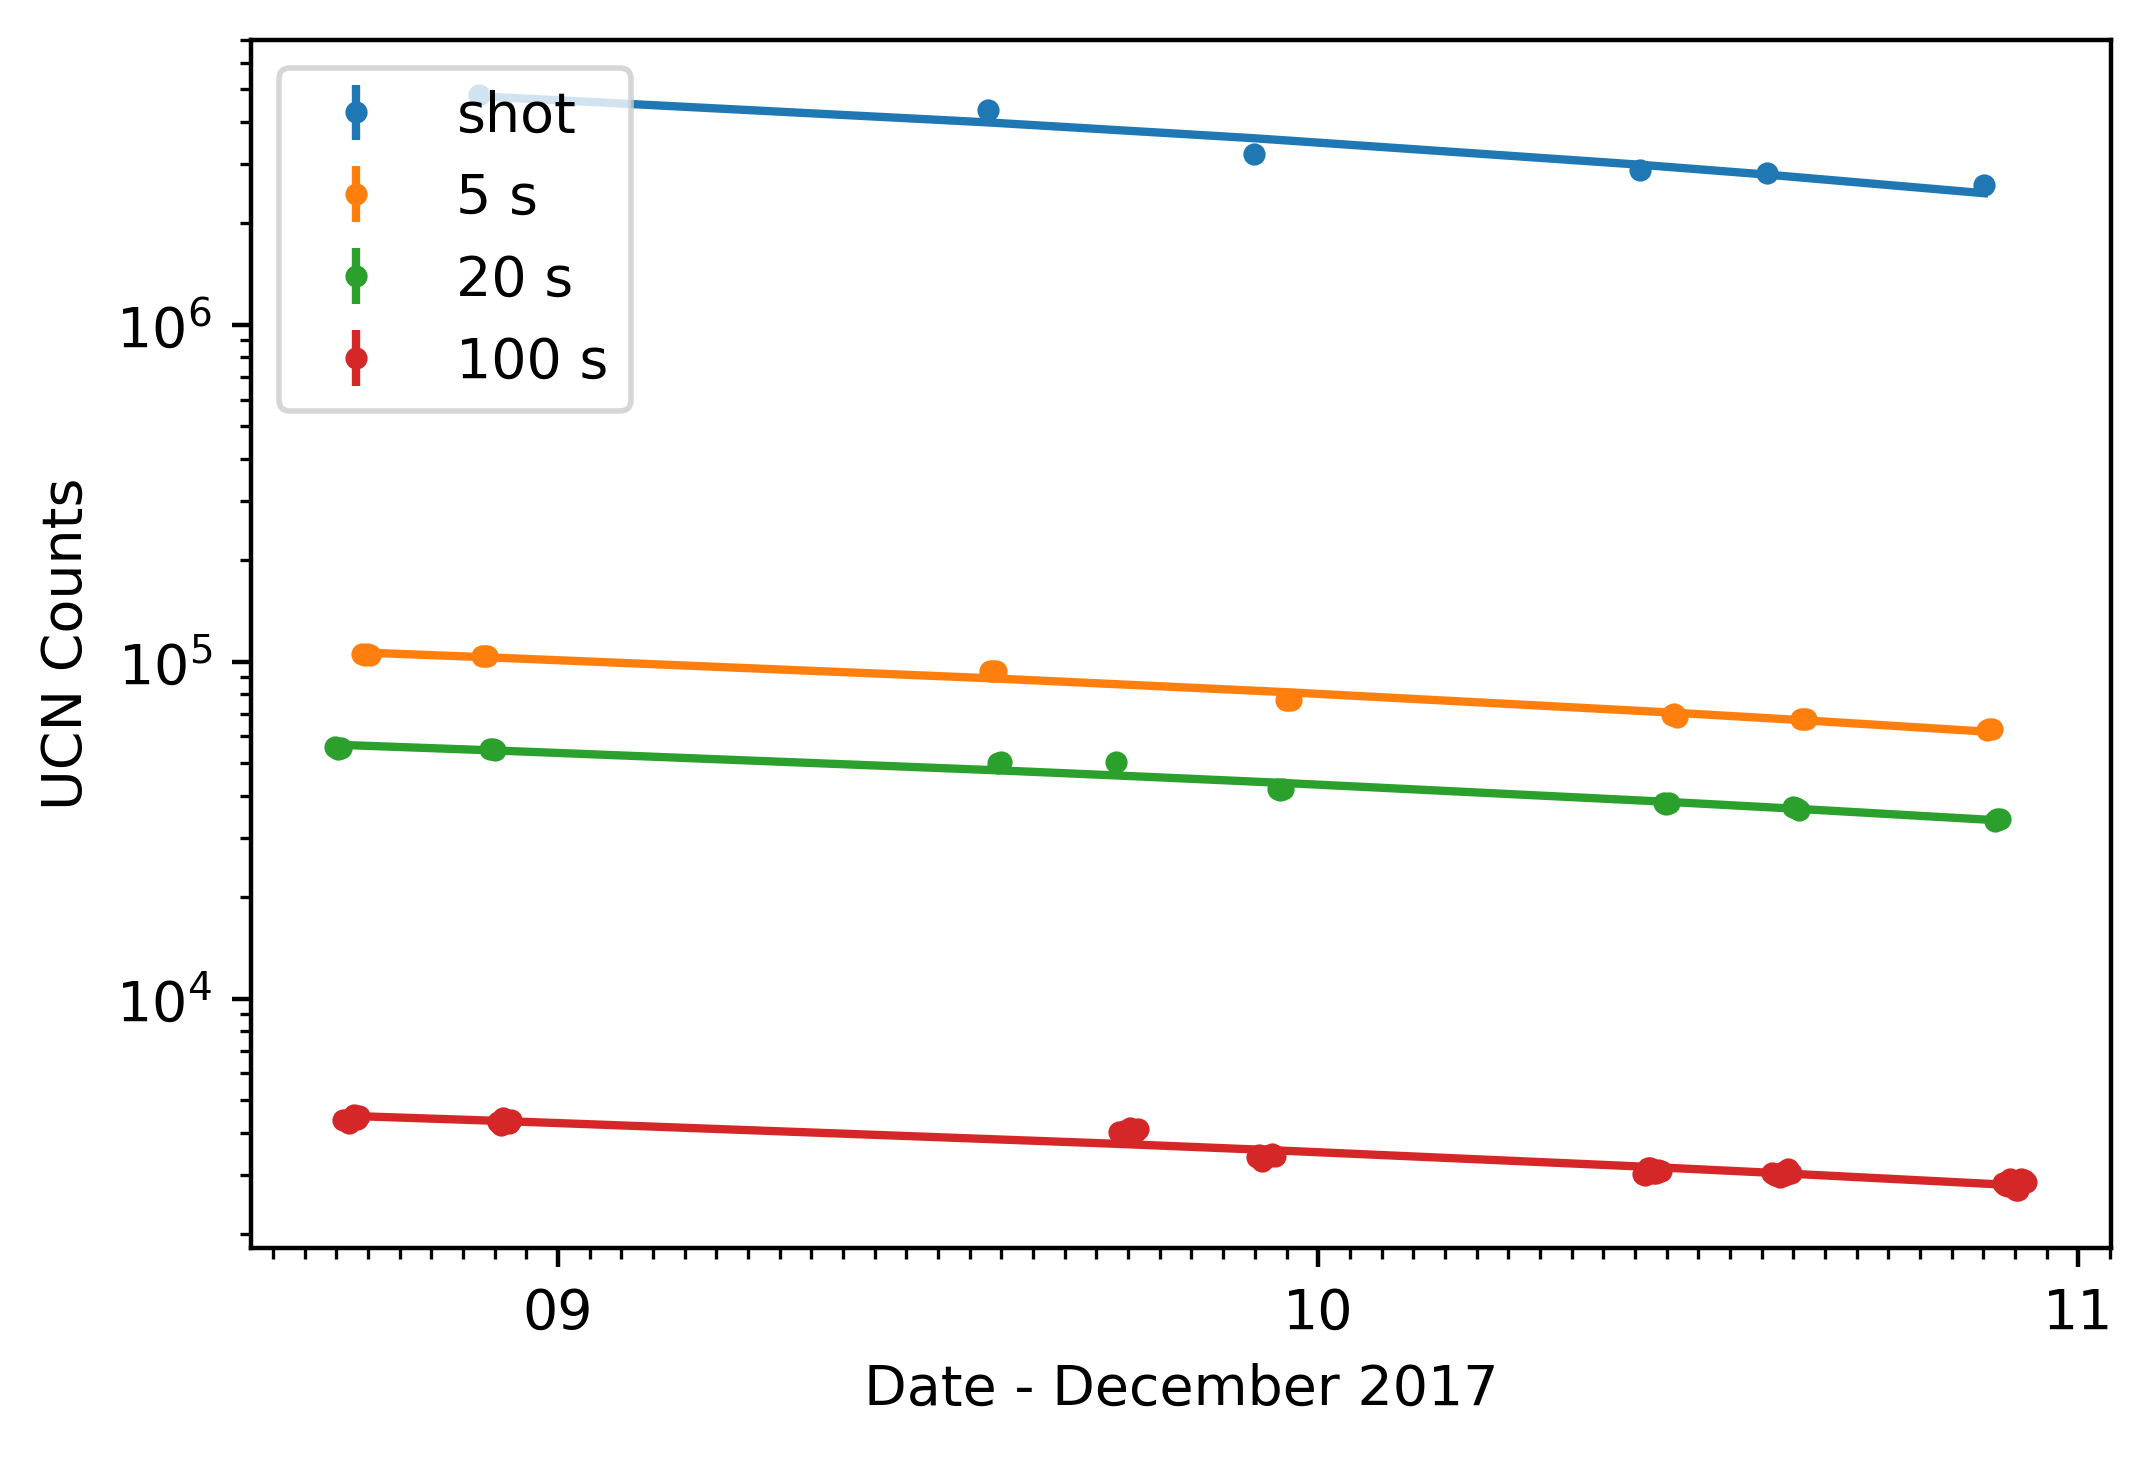

In [4]:
# for an all-in-one figure
fig_a, ax_a = plt.subplots()
ax_a = plt.gca()

# ax.errorbar(x,y,yerr = yerr, fmt = '.')
# ax.set_yscale('log')

# ax.set_ylabel('UCN Counts')

# ax.set_yscale('log')
# ax.grid(True)
# fig.savefig('../img/all_monitor.png', dpi = 600)

# iterate over each run type
for run_type in ['shot', 's005', 's020', 's100']:

    # load the main detector data for the TRIUMF-style normalization
    # configuration
    arr = load_main('NOMI', run_type, raw_unix_time_flag = True)
    
    # for colour consistency in plotting
    color = next(ax_a._get_lines.prop_cycler)['color']

    # for separate figures
#     fig, ax = plt.subplots()
    
    if (run_type == 'shot'):
        plot_label = run_type
    else:
        plot_label = str(int(run_type[1:4])) + ' s'
        
    x = [dt.datetime.fromtimestamp(d) for d in arr[:,0]]
    y = arr[:,2]
    yerr = arr[:,3]    
    
    
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
#     ax.xaxis.set_major_locator(mdates.DayLocator())
#     ax.xaxis.set_minor_locator(mdates.HourLocator())
        
#     # plotting the data and fit by pre-storage time; separate figures
#     ax.errorbar(x, y, yerr = yerr, fmt = '.',
#                 label = plot_label, color = color)
    
#     ax.plot(x, 
#             linear_fit(arr[:,0], 
#                        norm_dict[run_type, 'N_0'].nominal_value, 
#                        norm_dict[run_type, 'y'].nominal_value), 
#             color = color);



    # plotting the data by pre-storage time; all on one figure
    ax_a.errorbar(x, y, yerr = yerr, fmt = '.',
                label = plot_label, color = color)
    
    print(run_type + ': Red. Chi Squared = {}'.format(norm_dict[run_type, 'redchi']))
    print(run_type + ': degrees of freedom = {}'.format(norm_dict[run_type, 'nfree']))
    
    ax_a.plot(x, linear_fit(arr[:,0], 
                       norm_dict[run_type, 'N_0'].nominal_value, 
                       norm_dict[run_type, 'y'].nominal_value), 
              color = color);

    # presentation stuff for separated figures
#     ax.set_xlabel('Time Elapsed [s]');
#     ax.set_xlabel('Date - December 2017')
# #     ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     ax.set_ylabel('UCN Counts');
#     ax.legend();
#     ax.set_title('TRIUMF-style Normalization');

#     # printing the fit results below the figure
#     param_str = run_type + r': $N_0 = {}, \quad \gamma = {}$'
#     ax.text(0, -0.2, param_str.format(norm_dict[run_type, 'N_0'], 
#                                         norm_dict[run_type, 'y']),
#                                             transform=ax.transAxes);
#     fig.savefig('../img/' + plot_label[0:1] + '_norm.png')

# presentation stuff
ax_a.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax_a.xaxis.set_major_locator(mdates.DayLocator())
ax_a.xaxis.set_minor_locator(mdates.HourLocator())
ax_a.set_yscale('log')
ax_a.set_xlabel('Date - December 2017')
# ax_a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax_a.set_ylabel('UCN Counts');
ax_a.legend();
# ax_a.set_title('TRIUMF-style Normalization');
fig_a.savefig('../img/all_norm.pdf')

The error bar v. spread of the data suggests that there are systematic effects at play here that are not being properly accounted for with this simplistic linear model of sD2 degradation.

# Comparing UCN Count Degradation Rates for Different Pre-Storage Times

In order to compare the degradation rates - the slopes from the most recent figure - the rates must be re-scaled by the absolute count rates at time $t = 0$, the beginning of the experiment. 

Here the fit function is a simple linear model, 

$$N(t) = N_0 - \gamma_{sD_2} t$$

where $N_0$ would be the extrapolated number of counts for a hypothetical storage time at $t=0$. Here we define the $t=0$ time to be the start of the proton beam current measurements, as this is simply the earliest time stamp we have had to consider in the analysis of this experiment. The parameter $\gamma_{sD_2}$ is the loss rate of absolute UCN counts over time. Here the lowercase $\gamma$ is used to differentiate this rate from the characteristic decay rate $\Gamma$ of a single UCN.

In the figure below, the four fits to the nominal configuration data are plotted once more, but every data point (representing total counts in a given run) and its associated error bar are re-normalized based on the ratio of $N_0$ values from the fit. 

In [56]:
count_norm_dict = {}
count_norm_max_dict = {}

for run_type in ['s005', 's020', 's100']:

    arr = load_main('NOMI', run_type)
    uarr = unumpy.umatrix(arr[:,2], arr[:,3])
    max_count = uarr.max(1)[0,0]
    print(max_count)
    count_norm_dict[run_type] = max_count
    count_norm_max_dict[run_type] = max_count
#     count_norm_dict[run_type] = count_norm_dict[run_type] / count_norm_dict['s005']
#     print(run_type + ': {}'.format(ave_count))

for run_type in ['s005', 's020', 's100']:
# for run_type in ['s100', 's020', 's005']:
    count_norm_dict[run_type] = count_norm_dict['s100'] / count_norm_dict[run_type]

count_norm_dict

(6.260+/-0.025)e+04
(3.377+/-0.018)e+04
(2.70+/-0.05)e+03


{'s005': 0.043147654115880445+/-0.0008479452064876528,
 's020': 0.07998696991234305+/-0.0015994335838886654,
 's100': 1.0+/-0}

In [81]:
relative_dict = {}

for run_type in ['s005', 's020', 's100']:

    arr = load_main('NOMI', run_type)
    arr = arr[arr[:,0].argsort()]
    uarr = unumpy.umatrix(arr[:,2], arr[:,3])
    
    uarr = np.divide(uarr, uarr.max(1)[0,0])
    

In [82]:

uarr

matrix([[0.9617425917735515+/-0.020426086016691238,
         0.9670499778858912+/-0.020510057497761334,
         0.9440513047324193+/-0.02014588638714163,
         0.9714727996461743+/-0.020580003219862076, 1.0+/-0,
         0.9732419283502874+/-0.020607973810524132,
         0.9918177797434763+/-0.02090140439954292,
         0.9531180893409995+/-0.020289545949269495,
         0.9332153914197258+/-0.019974034218107506,
         0.9776647501105705+/-0.020677881197931434,
         0.9617425917735515+/-0.020426086016691238,
         0.9427244582043344+/-0.020124852788454474,
         0.9657231313578063+/-0.020489068388786388,
         0.8889871738168952+/-0.019270677040339457,
         0.8892083149049094+/-0.01927420184456442,
         0.8960636886333481+/-0.019383429585234587,
         0.8863334807607254+/-0.019228372859892283,
         0.9128704113224237+/-0.01965088259866013,
         0.8984962406015038+/-0.019422168782045474,
         0.8867757629367536+/-0.019235424395468277,
       

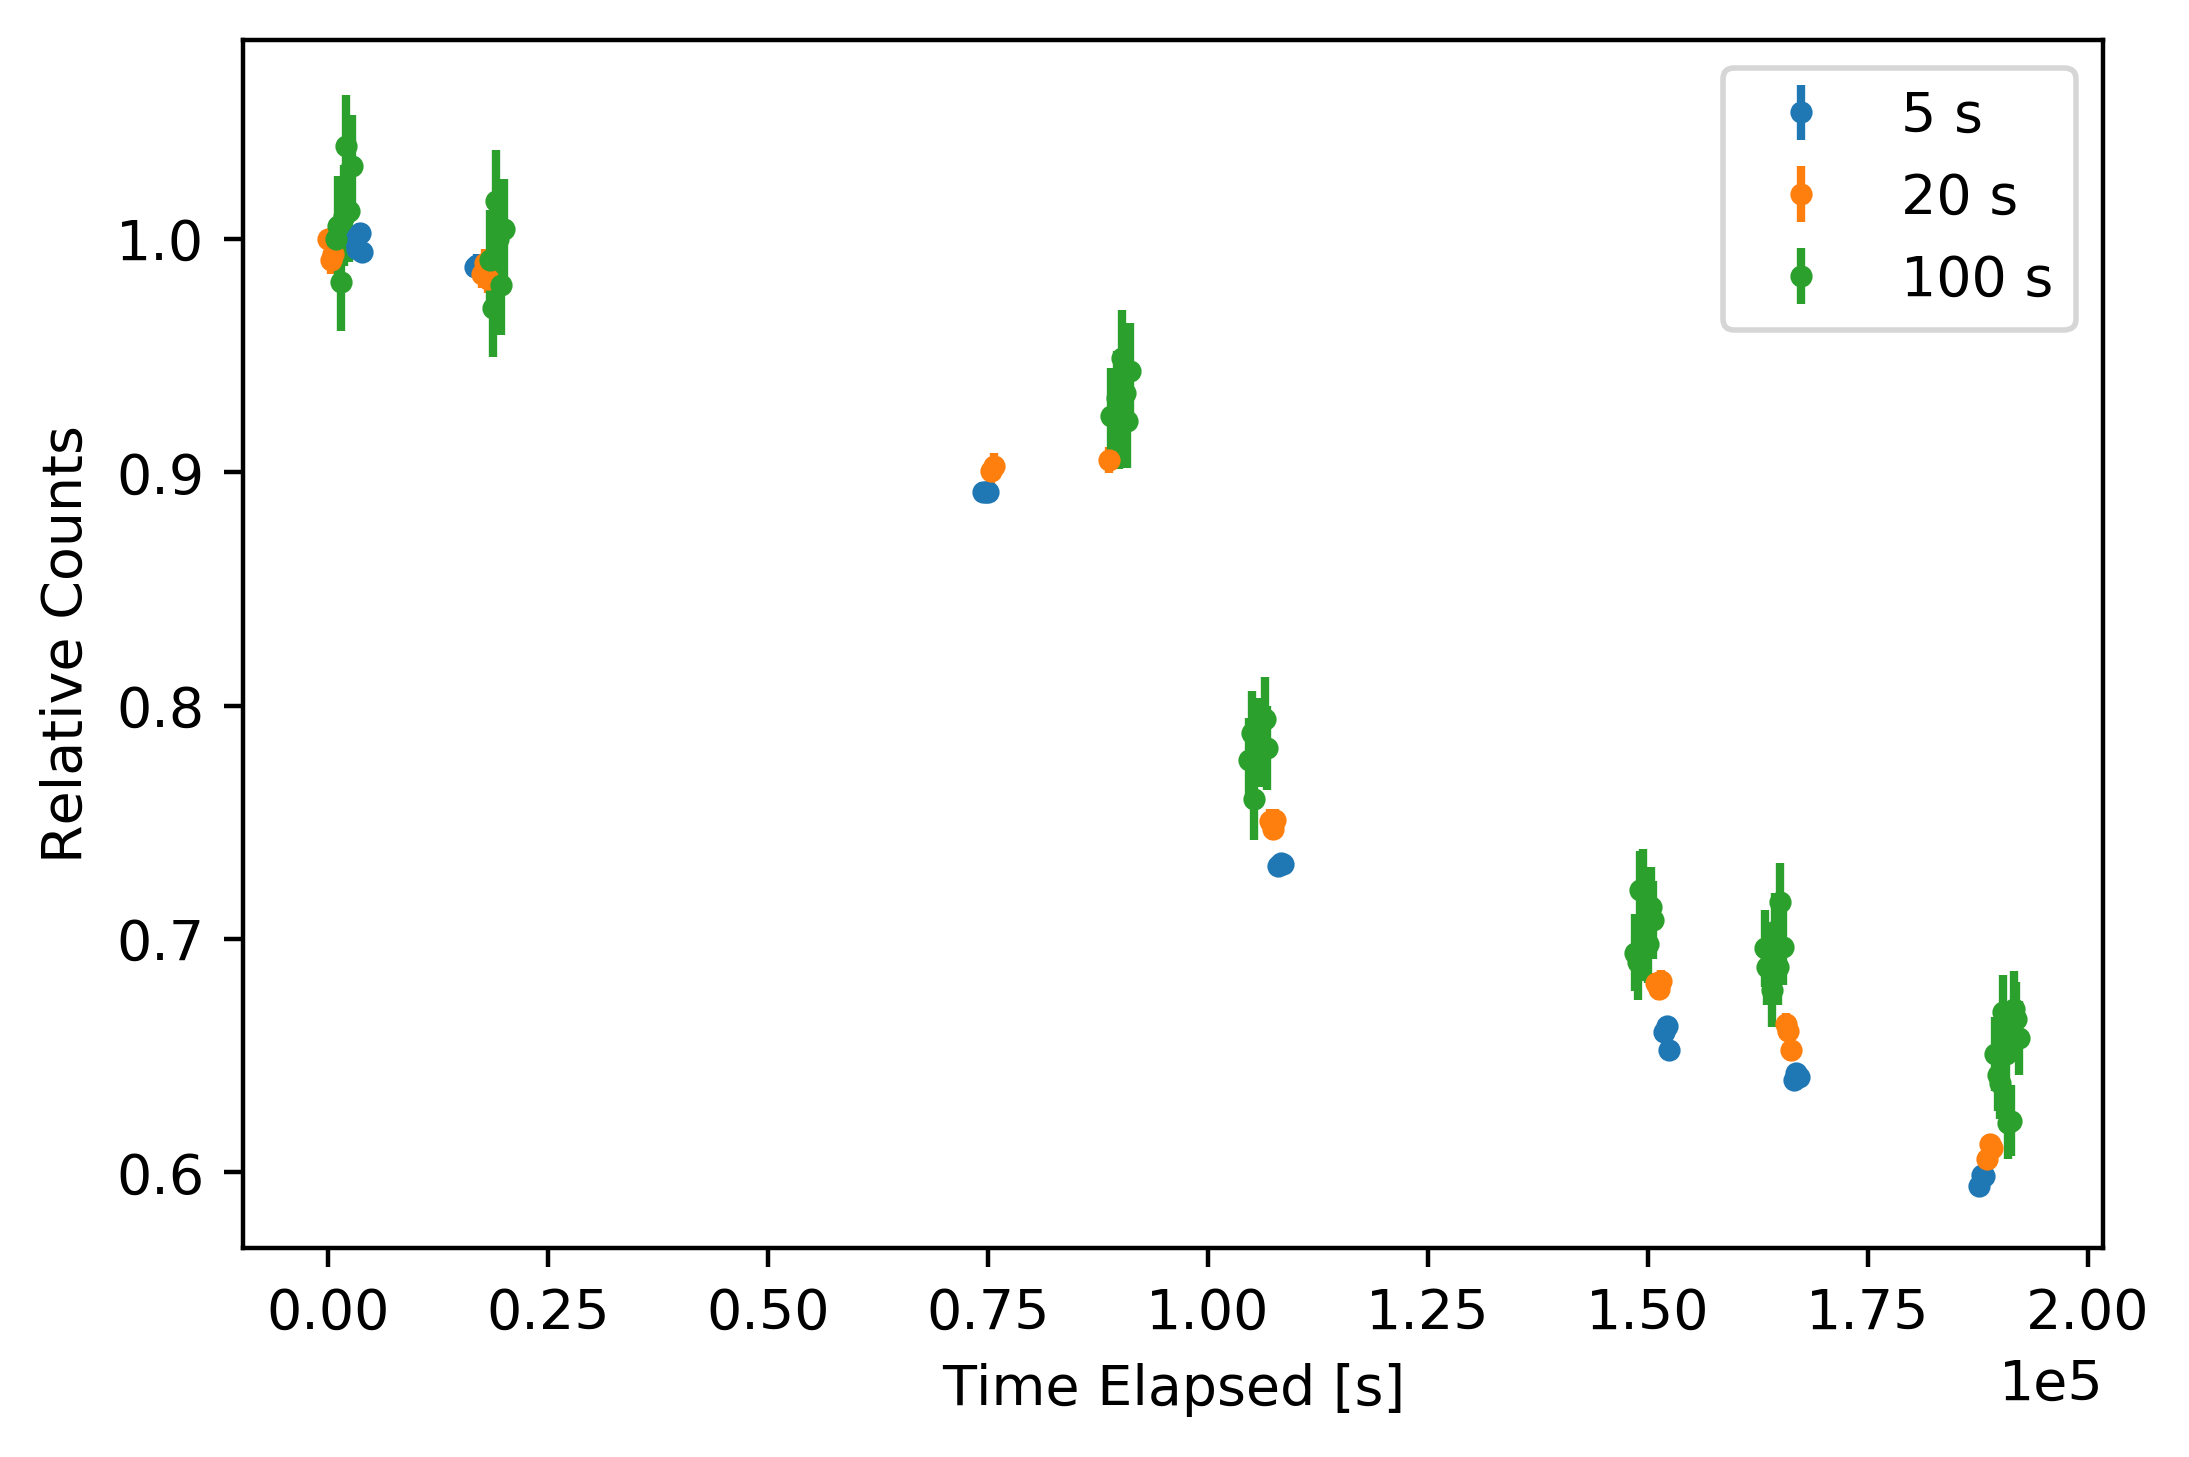

In [92]:
# !!! Really we should be reproducing the relative counts plot of the Anghel paper.
# !!! Then the follow up could be doing a similar loss analysis from the monitor detector, to confirm there
# is something awry

# for a figure plotting the three fits
fig, ax = plt.subplots()
ax = plt.gca()

# for a figure plotting the parameter values of the fits
# fig_s, ax_s = plt.subplots()

# iterate over each run type to be normalized. 
# normalizing to the s005 values
# i = 0
for run_type in ['s005', 's020', 's100']:
    
    # compute the factor by which to normalize absolute counts
    # convert to a factor based upon averaged counts, post-normalization, as this will reduce any weighting based on where the runs occurred
#     norm_factor = norm_dict['s005', 'N_0'] / norm_dict[run_type, 'N_0']

    # load the main detector data for the TRIUMF-style normalization
    # configuration
#     arr = load_main('NOMI', run_type)
#     new_arr = np.empty(np.shape(arr), float)
    
    # This gets an array of the run data where every count
    # value is a fraction representing the count relative to the starting value
    # This also solves the problem because now we don't have to fit at all,
    # or scale
    arr = load_main('NOMI', run_type)
    arr = arr[arr[:,0].argsort()]
    uarr = unumpy.umatrix(arr[:,2], arr[:,3])
    uarr = np.divide(uarr, uarr[0,0])
    
    # for colour consistency in plotting
    color = next(ax._get_lines.prop_cycler)['color']
    
    # generate uncertainty array of the run data
#     uarr = unumpy.umatrix(arr[:,2], arr[:,3])

    # normalize the run data
    # instead of fitting normalized data, we should be scaling the fit
#     uarr = np.multiply(uarr, count_norm_dict[run_type])

    # update the array values, and hence the dictionary by mutablity in python
    arr[:,2] = unumpy.nominal_values(uarr)
    arr[:,3] = unumpy.std_devs(uarr)

    # plotting the data and fit by pre-storage time; separate figures
    ax.errorbar(arr[:,0], 
                arr[:,2], 
                yerr = arr[:,3], 
                fmt = '.',
                label = str(int(run_type[1:4])) + ' s', 
                color = color)
    
    # performing a linear fit
    # use lmfit here
#     popt, pcov = curve_fit(linear_fit, arr[:,0], arr[:,2], 
#                         sigma = arr[:,3], absolute_sigma = True)
    
    # lmfit implementation
    ### Using lmfit to perfom fit of source norm data
#     t      = arr[:, 0]
#     counts = arr[:, 2]
#     gmodel = Model(linear_fit)
#     params = gmodel.make_params(N_0=10000, y=0.24)
#     result = gmodel.fit(counts, 
#                         params, 
#                         t=t, 
#                         weights = 1/arr[:,3])
    
#     print('\n### ' + run_type + ' ###')
#     print(result.fit_report())
#     print(result.best_fit)
    
#     N_0 = ufloat(result.params['N_0'].value, result.params['N_0'].stderr)
#     y   = ufloat(result.params['y'].value, result.params['y'].stderr)
    
#     y = np.multiply(y, count_norm_dict[run_type])
    
#     ax_s.errorbar([run_type], y.nominal_value, yerr = y.std_dev, 
#                   fmt = '.', color = color)
    
#     ax.plot(arr[:,0], 
#             linear_fit(arr[:,0], *popt),
#             color = color);
        
#     ax.plot(t, 
#             result.best_fit * count_norm_dict[run_type].nominal_value,
#             color = color);

#     # plotting the data by pre-storage time; all on one figure
#     ax_a.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.',
#                 label = run_type, color = color)
#     ax_a.plot(arr[:,0], linear_fit(arr[:,0], 
#                        norm_dict[run_type, 'N_0'].nominal_value, 
#                        norm_dict[run_type, 'y'].nominal_value), 
#               color = color);

#     # presentation stuff for separated figures
#     ax.set_xlabel('Time Elapsed [s]');
#     ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#     ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#     ax.set_ylabel('UCN Counts');
#     ax.legend();
#     ax.set_title('Nominal Configuration - Main Detector');

    # printing the fit results below the figure
#     param_str = run_type + r': $N_0 = {}, \quad \gamma = {}$'
#     ax.text(0, -0.2 + i, param_str.format(N_0, y),transform = ax.transAxes);
#     i = i - 0.1

# presentation stuff
ax.set_xlabel('Time Elapsed [s]');
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel('Relative Counts');
ax.legend();
fig.savefig('../img/relative_norm.pdf')

# ax.set_title('TRIUMF-style Normalization');

# ax_s.set_xlabel('Run Type');
# ax_s.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax_s.set_ylabel('UCN Counts');
# ax_s.set_title('TRIUMF-style Normalization');

In the second figure I've plotted the slope values found in the above fits, after the absolute counts ($N_0$) normalization. 

This doesn't make sense. Following this normalization we would expect the oppposite trend to be seen, namely that direct shot measurements are the most sensitive.

Bernhard's reflections on the normalization plot shown above:

> concerning your plot, this is interesting as I would have expected the opposite <br/>
we know and have several times measured,, that the build up of the frost on the<br/>
surface<br/>
see Anghel et al   Eur. Phys. J. A (2018) 54: 148<br/>
acts as energy filter - i.e. the longer the source is operated the intensity decreases and<br/>
the intensity decreases stronger for lower energy UCNs<br/>
therefore the longer storage times should be more strongly suppresed<br/>
 see Fig. 7 and 8 in the paper .<br/><br/>
In this paper you can also find, that it is not a decay of UCN production we observe but<br/>
an increase in losses due to buildup of frost on the surface- have a look.<br/><br/>
So my first thought would be, that there might be some effect in your analysis,<br/>
with is not yet considered or missing or unknown, which makes this change.<br/>
Might have to do something with monitoring, but I don;t know right away.<br/>
But one should certainly look at that closer.

The key figure from this paper that should cause some revisitation of the normalization analysis:

![](../img/frost_paper_fig.png)
![](jonahberean/psi_transmission/img/frost_paper_fig.png)

And from the paper:

>The West-1 beamport is located about 1.13 m and<br/>
the West-2 beamport 3.23 m above the sD 2 surface. This<br/>
results in a relative shift of the UCN energy spectra at the<br/>
two beamports. UCN which can reach the higher beam-<br/>
port have a minimum energy of 320 neV outside the sD 2<br/>
surface, while UCN at West-1 have a minimum energy of<br/>
113 neV, similar to the kinetic energy boost by the sD 2<br/>
potential [45,46].

So clearly we're getting this backwards, and the results need to be revisited.

In [31]:
for config in ['shot', 's005', 's020', 's100']:
    for param in ['N_0', 'y']:
        print(config + ' ' + param)
        print(norm_dict[config, param])

shot N_0
(2.0438+/-0.0021)e+10
shot y
13.507+/-0.014
s005 N_0
(3.646+/-0.014)e+08
s005 y
0.2409+/-0.0009
s020 N_0
(1.833+/-0.010)e+08
s020 y
0.1211+/-0.0007
s100 N_0
(1.354+/-0.019)e+07
s100 y
0.00895+/-0.00013


# Propagating an Error associated with this Normalization

The error on an individual measurement, or run is given by Poisson statistics to be $\sqrt{N}$, where $N$ is the number of counts measured. From the four fits performed on this nominal configuration data, data in other configurations can be normalized based on the time stamp of their occurrence. The following normalization factor, $S$, will be used:

$$S = \frac{N_0^\mathrm{nom}}{N^\mathrm{nom}(t)}$$

where $N_0^\mathrm{nom}$ is the value of $N_0$ from the run-type-specific fit, and $N^\mathrm{nom}(t)$ is the value of $N$, counts, at time $t$ along the fit. The denominator term is an interpolation along the nominal configuration data fit, for run times of other runs, in other configurations. The error associated with $N_0^\mathrm{nom}$ is extracted from the fits above, and the error associated with $N^\mathrm{nom}(t)$ is simply propagated using the linear fit equation:

$$ \delta N^\mathrm{nom}(t) = \sqrt{\left (\delta N^\mathrm{nom}_0 \right )^2 + \left ( \delta \gamma^\mathrm{nom} \right )^2}$$

where the error a

The fractional uncertainty associated with the quantity $S$ as a whole is then:

\begin{align} 
\frac{\delta S}{S} = \sqrt{\left (\frac{\delta N_0^\mathrm{nom}}{N_0^\mathrm{nom}} \right )^2 + \left (\frac{\delta N^\mathrm{nom}(t)}{N^\mathrm{nom}(t)} \right )^2}
\end{align}

The counts for a single run, following normalization, are computed as $N' = N \cdot S$. This means that the resulting, fractional, statistical uncertainty on counts for a single run will be

\begin{align} 
\frac{\delta N'}{N'} = \sqrt{\left (\frac{\delta N}{N} \right )^2 + \left (\frac{\delta S}{S} \right )^2}
\end{align}